In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import functools 
import operator

from sklearn import utils

import datetime
import csv
#import nltk
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split

# Data Loading & Preprocessing Methods
- extract datetype data info
    - year, month, day
- detect outlier
- preprocess strings for categorical data
- print categorical data

In [2]:
# path for the csv files
DATA_PATH = os.path.join(os.getcwd(), 'data')

# loading data to pandas dataframe
def load_data(file_name): 
    file_path = os.path.join(DATA_PATH, file_name) 
    return pd.read_csv(file_path, parse_dates = ['purchase_date', 'release_date'])

def extract_dateinfo(df, col_name, datetype='year'):
    '''
    extract date type into specific year, month, date
    '''
    date_type = {'year': df[col_name].dt.year, 'month': df[col_name].dt.month, 'day': df[col_name].dt.day}[datetype]
    
    df.loc[:, col_name+'_'+ datetype] = date_type
    return df

#Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    for col in features:
        # calculating interquartile range
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR  
        
        # get the indices of outliers for feature col
        outliers_in_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the indices to oulier_indices
        outlier_indices.extend(outliers_in_col)
    
    outlier_indices = Counter(outlier_indices)
    result = list(k for k, v in outlier_indices.items() if v > n)
    
    return result

def process_string(string):
    '''
    split strings in categories/tags/genres 
    make all the words in lowercase
    remove all '-'
    '''
    string = string.lower()
    punctuation = "-"
    
    string = ''.join('' if c.isalpha()==False else c for c in string)
    
    return string

def get_cate_type_data(df, column_name):
    cate_list = list(df[column_name].apply(lambda x: set(x)))
    cate_list = set(functools.reduce(operator.iconcat, cate_list, []))
    return (column_name + ' list: ' + str(cate_list) + '\n\n')
    


# Applying Preprocessing Methods
1. load data
2. drop outlier
3. merge training dataset and testing dataset
4. filling NaN
5. convert boolean value to 0 & 1
6. preprocess categorical data

In [3]:
train_set = load_data('train.csv')
test_set = load_data('test.csv')

# Drop outliers from training data
outliers_to_drop = detect_outliers(train_set, 1 ,['price', 'total_positive_reviews', 'total_negative_reviews'])
train_set.loc[outliers_to_drop]
train_set = train_set.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

train_len = train_set.shape[0]
test_len = test_set.shape[0]

# merge training data and testing data 
game_info =  pd.concat(objs=[train_set, test_set], axis=0, sort=False).reset_index(drop=True)

#fill missing purchase date with the most frequent value in purchase_date column
game_info['purchase_date'].fillna(game_info['purchase_date'].mode()[0], inplace=True)


#fille missing number of positive_reviews and negative_reviews with zeros
game_info['total_positive_reviews'].fillna(0.0, inplace=True)
game_info['total_negative_reviews'].fillna(0.0, inplace=True)

#print(game_info.isnull().any().any())
game_info['total_reviews_count'] = game_info['total_positive_reviews'] + game_info['total_negative_reviews']

#transfer boolean values to 1(true) and 0(false)
game_info['is_free'] = game_info['is_free'].map({False: 0.0, True: 1.0})

# extract year value
game_info = extract_dateinfo(game_info, 'purchase_date')
game_info = extract_dateinfo(game_info, 'release_date')
game_info['time_interval'] = game_info['purchase_date_year'] - game_info['release_date_year']
game_info.drop(columns=['purchase_date', 'release_date'], inplace=True)

game_info.drop(columns=['id'], inplace=True)


# split strings in the categorical columns
game_info['genres'] = game_info['genres'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['categories'] = game_info['categories'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['tags'] = game_info['tags'].str.split(',').apply(lambda x: list(map(process_string, x)))

temp_cate_df = game_info[['genres', 'categories', 'tags']]

def __unique_tags__(row):
    col1 = row.iloc[0]
    col2 = row.iloc[1]
    col3 = row.iloc[2]
    one_two = set(col1) | set(col2)
    return list(one_two | set(col3))

game_info.loc[:, 'all_cate'] = temp_cate_df.apply(__unique_tags__, axis=1)
game_info.loc[:, 'cate_count'] = game_info['all_cate'].apply(lambda x: len(x))

# Methods for Exploring Categorical Data
1. create dataframe for one-hot categorical data & play time
2. get the mean play time under each categorical data
3. create dataframe containing mean play time and number of games under each categorical data

In [8]:
def create_cate_type_df(cate_type='categories'):
    '''
    return one hot dataframe with 'playtime_forever'
    '''
    
    cate_df = game_info.loc[:, ['playtime_forever', cate_type]]
    temp = pd.get_dummies(cate_df[cate_type].apply(pd.Series).stack()).sum(level=0)
    cate_df = pd.concat([cate_df, temp], axis=1, sort=False).drop(columns=[cate_type])
    
    return cate_df



def get_mean_time_df(cate_df):
    '''
    index: tages/categories/genres
    columns: 
        number of game in that cate/tag/genre
        mean play time of all the games in that cate/tag/genre
    '''
    cate_df_copy = cate_df.copy()
    
    def __get_mean_playTime__(column):
        temp = cate_df_copy.loc[cate_df_copy[column.name] > 0]
        return temp['playtime_forever'].mean(skipna=True)
    
    
    mean_play_time_series = cate_df_copy.apply(__get_mean_playTime__, axis=0).drop(['playtime_forever'])
    
    
    cate_df_copy = cate_df_copy.transpose()
    
    cols = cate_df_copy.columns
    bt = cate_df_copy.apply(lambda x: x > 0)
    
    # number of game for each category
    num_game = bt.apply(lambda x: len(cols[x.values]), axis=1).drop(['playtime_forever'])
    
    cate_df_copy = pd.concat([num_game, mean_play_time_series], axis=1)
    cate_df_copy.columns = ['num of games', 'mean play time']
    
    return cate_df_copy.sort_values(by=['mean play time'])



def get_correlation(game_info, category_df):
    #cate_df = game_info[['genres', 'categories', 'tags']]
    game_df_copy = game_info.copy()
    #game_df_copy.loc[:, 'all_cate'] = cate_df.apply(__unique_tags__, axis=1)
    game_df_copy.drop(columns=['genres', 'categories', 'tags'], inplace=True)
    
    cate_df = pd.get_dummies(game_df_copy['all_cate'].apply(pd.Series).stack()).sum(level=0)
    game_df_copy = pd.concat([game_df_copy, cate_df], axis=1).drop(columns=['all_cate'])
    
    features = list(category_df.columns) 
    corr = game_df_copy[features].corr()
    
    return corr

def get_high_corr_list(corr, threshold=0.1):
    '''
    |correlation| > 0.1
    '''
    corr_list = corr.iloc[0,:].sort_values(ascending=False).drop('playtime_forever')
    corr_list = list(corr_list[np.abs(corr_list.values) > threshold].index)
    
    return corr_list

def get_cate_info(cate_type='categories'):
    '''
    info
        - df
        - correlation df
        - high correlation item list
        - mean time df
    '''
    info = {}
    
    df = create_cate_type_df(cate_type=cate_type)
    info['df'] = df
    
    corr_df = get_correlation(game_info, df)
    info['corr_df'] = corr_df
    
    high_corr_list = get_high_corr_list(corr_df, threshold=0.18)
    info['high_corr_list'] = high_corr_list
    

    info['mean_time_df'] = get_mean_time_df(df)
    
    return info

# Graphing Methods
- graph mean time under each tag

In [9]:
def plot_mean_time(mean_time_df, figsize=(50, 3)):

    names = list(mean_time_df.index.values)
    values = list(mean_time_df.iloc[:, 1])

    plt.figure(figsize=figsize)
    plt.scatter(names, values)
    plt.show()

def plot_heat_map(corr, figsize=(30, 9)):
    plt.figure(figsize=figsize)
    g = sns.heatmap(corr, annot=True, cmap = "coolwarm")

# Exploring Data

In [26]:
genre_info = get_cate_info(cate_type='genres')
cate_info = get_cate_info(cate_type='categories')
tag_info = get_cate_info(cate_type='tags')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater


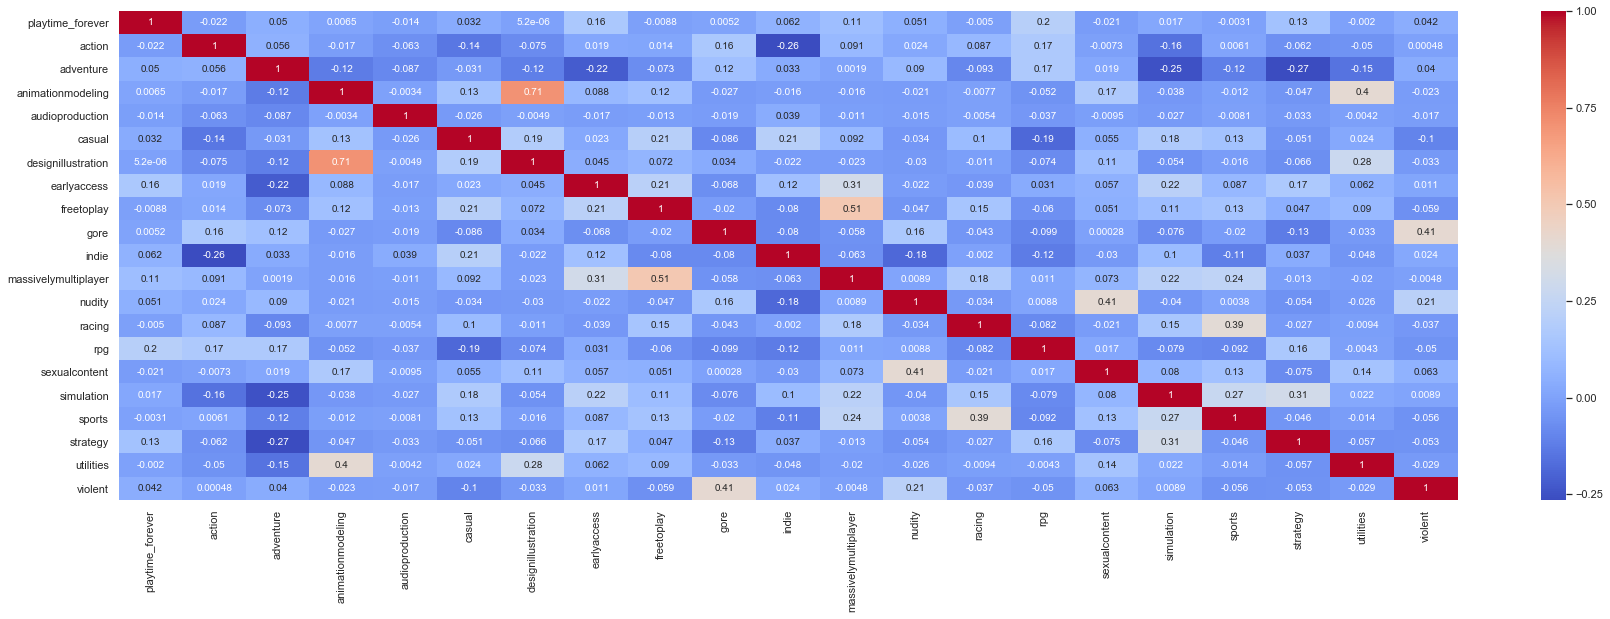

In [27]:
genre_info['high_corr_list']
genre_corr = genre_info['corr_df']
plot_heat_map(genre_corr, figsize=(30, 9))

In [28]:
tag_info['high_corr_list']

['turnbasedcombat',
 'touchfriendly',
 'turnbasedtactics',
 'partybasedrpg',
 'crpg',
 'turnbased',
 'rpg',
 'addictive',
 'fantasy']

In [29]:
tag_info['corr_df'].iloc[:, 0].sort_values(ascending=False)

playtime_forever    1.000000
turnbasedcombat     0.325938
touchfriendly       0.294061
turnbasedtactics    0.269130
partybasedrpg       0.229756
                      ...   
coldwar                  NaN
gamemaker                NaN
lorerich                 NaN
modern                   NaN
onrailsshooter           NaN
Name: playtime_forever, Length: 315, dtype: float64

In [30]:
cate_info['high_corr_list']

['steamworkshop', 'remoteplayontv']

# Obtain Features

In [33]:
# doc for new categorization criteria 
cate_list = open('cate_list.txt').read()
new_cate= cate_list.split('\n\n')

# new category names as keys
# content for each category as values
cate_dic = {}
for i in new_cate:
    entry = i.split('\n')
    cate_dic[entry[0]] = entry[1:]

# decide new category for each game
# by comparing tags & categories & genres with new criteria
def decide_new_cate(cate_each_game):
    new_cate = []
    for i in list(cate_dic.keys()):
        if len(set(cate_each_game).intersection(set(cate_dic[i]))) > 0:
            new_cate.append(i)
    return new_cate

new_cate = game_info['all_cate'].apply(decide_new_cate)

one_hot = MultiLabelBinarizer()
new_cate_df = pd.DataFrame(one_hot.fit_transform(new_cate), columns=list(cate_dic.keys()))



In [34]:
high_corr_unique = set(genre_info['high_corr_list'] + cate_info['high_corr_list'] + tag_info['high_corr_list'])


In [35]:
high_corr_unique

{'addictive',
 'crpg',
 'fantasy',
 'partybasedrpg',
 'remoteplayontv',
 'rpg',
 'steamworkshop',
 'touchfriendly',
 'turnbased',
 'turnbasedcombat',
 'turnbasedtactics'}

In [36]:
game_df_copy = game_info.copy()
cate_df = pd.get_dummies(game_df_copy['all_cate'].apply(pd.Series).stack()).sum(level=0)
cate_df = cate_df.loc[:, list(high_corr_unique)]
game_df_copy = pd.concat([game_df_copy, cate_df, new_cate_df], axis=1).drop(columns=['all_cate'])

In [37]:
game_df_copy.drop(columns=['genres', 'categories', 'tags'])

,playtime_forever,is_free,price,total_positive_reviews,total_negative_reviews,total_reviews_count,purchase_date_year,release_date_year,time_interval,cate_count,...,steamworkshop,fantasy,remoteplayontv,touchfriendly,turnbased,crpg,action,action-adventure,simulation,sports
0,0.000000,0.0,3700.0,372.0,96.0,468.0,2018,2013,5,15,...,0,0,0,0,0,0,0,1,0,0
1,0.016667,1.0,0.0,23.0,0.0,23.0,2016,2015,1,7,...,0,0,0,0,0,0,0,1,0,0
2,0.000000,0.0,5000.0,3018.0,663.0,3681.0,2018,2014,4,23,...,0,0,0,0,0,0,0,1,0,0
3,1.533333,0.0,9900.0,63078.0,1746.0,64824.0,2016,2010,6,23,...,1,1,0,0,0,0,1,1,1,0
4,22.333333,0.0,4800.0,8841.0,523.0,9364.0,2018,2012,6,25,...,0,1,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,NaN,0.0,5000.0,9334.0,516.0,9850.0,2018,2013,5,25,...,0,0,0,0,0,0,1,1,0,0
410,NaN,0.0,3600.0,1245.0,176.0,1421.0,2018,2009,9,20,...,0,0,0,0,0,0,1,1,0,0
411,NaN,0.0,11200.0,33128.0,6350.0,39478.0,2018,2013,5,25,...,1,0,0,0,0,0,0,0,1,0
412,NaN,1.0,0.0,5.0,0.0,5.0,2017,2017,0,16,...,0,0,0,0,0,0,1,1,1,0


In [38]:
features = ['playtime_forever'] + list(high_corr_unique) + list(new_cate_df.columns)
temp = game_df_copy[features].corr().iloc[0,:].sort_values()


In [39]:
other_info = ['total_reviews_count', 'purchase_date_year', 'time_interval', 'cate_count']

In [40]:
game_df_copy = game_df_copy.loc[:, features+other_info].drop(columns=['action'])


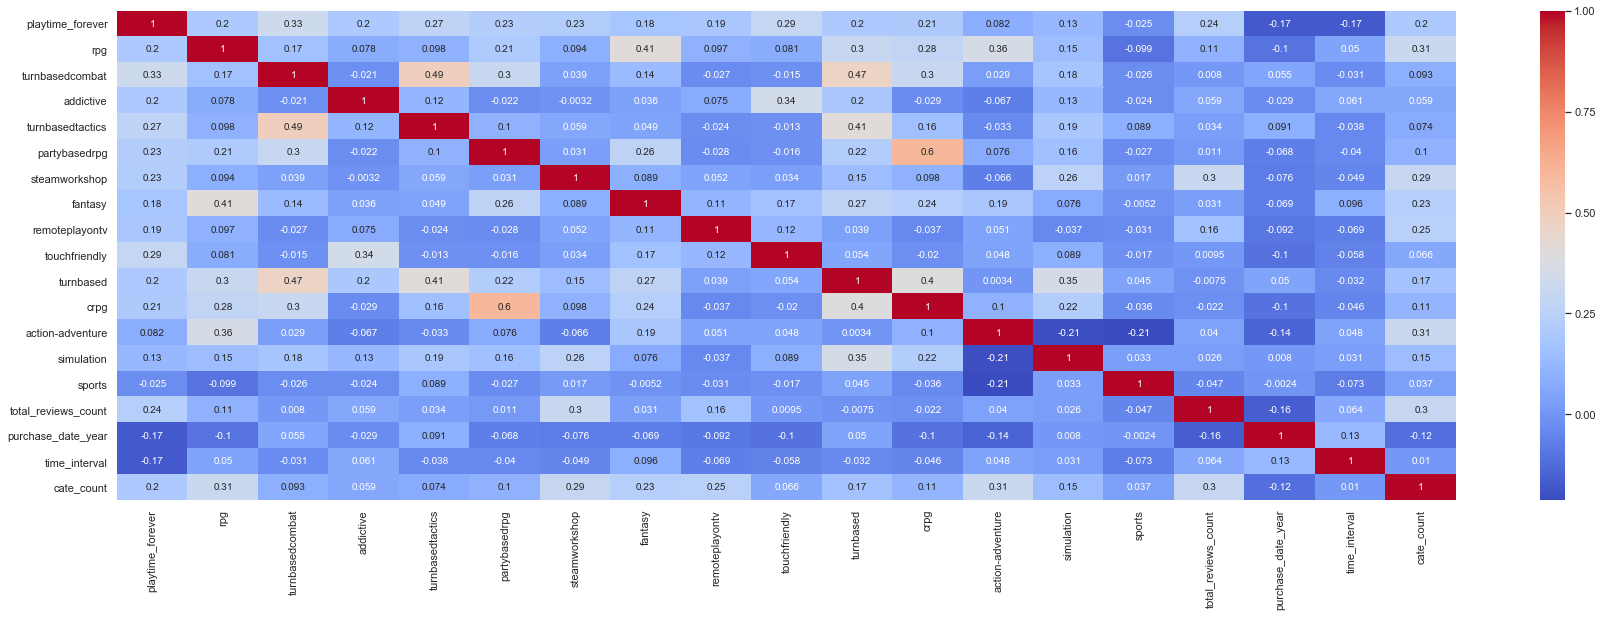

In [41]:
temp = game_df_copy[game_df_copy.columns].corr()
plot_heat_map(temp)

# Training

In [288]:
from sklearn import datasets, linear_model

from sklearn.decomposition import PCA


from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import lightgbm as lgb


In [289]:
data_df = game_df_copy.copy()
train_data = data_df[:train_len]
test_data = data_df[train_len:]

train_label = train_data['playtime_forever']
train_data = train_data.drop(columns=['playtime_forever'])
test_data.drop(columns=['playtime_forever'],inplace=True)


print('train_data shape: ', train_data.shape)
print('train_label shape: ', train_label.shape)
print('test_data shape : ', test_data.shape)

train_data shape:  (351, 14)
train_label shape:  (351,)
test_data shape :  (90, 14)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [290]:
# pca = PCA(n_components=5)
# pca.fit(train_data)
# train_data = pca.transform(train_data)
#X_val = pca.transform(X_val)
#test_data = pca.transform(test_data)

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data)
    rmse= np.sqrt(-cross_val_score(model, train_data, train_label, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [291]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [292]:
lasso_score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(lasso_score.mean(), lasso_score.std()))

enet_score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(enet_score.mean(), enet_score.std()))

# krr_score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(krr_score.mean(), krr_score.std()))

# gboost_score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(gboost_score.mean(), gboost_score.std()))


xgb_score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(xgb_score.mean(), xgb_score.std()))


lgb_score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(lgb_score.mean(), lgb_score.std()))



Lasso score: 9.6313 (3.3166)

ElasticNet score: 9.6275 (3.3146)



/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost score: 9.6332 (4.0858)

LGBM score: 8.5614 (3.5610)



In [293]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [294]:
averaged_models = AveragingModels(models = (ENet, lasso, model_xgb, model_lgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


 Averaged base models score: 8.7840 (3.5121)



In [295]:
#model1 = make_pipeline(StandardScaler(), Ridge(alpha=0.0001))
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
scores = cross_val_score(averaged_models, train_data, train_label, cv=cv, scoring='neg_mean_squared_error')

#model = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)
#scores = cross_val_score(model, train_data, train_label, cv=5, scoring=neg_mean_squared_erro)
print(np.sqrt(np.abs(scores)))

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[ 9.82333815 16.37514608 15.07043191 17.36318233 12.94337817]


In [296]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.2, random_state=42)

model2 = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)
averaged_models.fit(X_train, y_train)
model2.fit(X_train, y_train)
y_val_pred1 = averaged_models.predict(X_val)
y_val_pred2 = model2.predict(X_val)



print("Average Model Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, y_val_pred1)))
print("Ridge Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, y_val_pred2)))

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Average Model Root Mean squared error:  12.83360808586507
Ridge Root Mean squared error:  13.245331115195292


In [297]:
model2.fit(X_train, y_train)
y_test_pred = model2.predict(test_data)

averaged_models.fit(train_data, train_label)
y_pred1 = averaged_models.predict(test_data)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


# Export Result

In [31]:
def import_result(y_test_pred, filename):
    result_df = pd.DataFrame(y_test_pred, columns =['playtime_forever']) 
    result_df.index.name = 'id'
    result_df.to_csv(filename)

In [32]:
import_result(y_pred1, 'result.csv')